In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import plotly
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
import statsmodels
from statsmodels.tsa.stattools import coint
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import fxcmpy
con = fxcmpy.fxcmpy(config_file = '/Users/ballmdr/blockchain-python/FXCM/fxcm.cfg')

def z(df):
    return (df - df.mean()) / df.std()

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [16]:
symbols = ['EUR/USD', 'USD/JPY', 'GBP/USD', 'USD/CAD', 'USD/CHF', 'AUD/USD', 'NZD/USD', 'EUR/AUD', 'EUR/CAD', 'EUR/CHF', 'EUR/GBP', 'EUR/JPY', 'EUR/NZD', 'GBP/AUD', 'GBP/CAD', 'GBP/CHF', 'GBP/JPY', 'GBP/NZD', 'AUD/CAD', 'AUD/CHF', 'AUD/JPY', 'AUD/NZD', 'NZD/CAD', 'NZD/CHF', 'NZD/JPY', 'CAD/CHF', 'CAD/JPY', 'CHF/JPY']

In [2]:
symbols = ['USD/CHF', 'GBP/USD', 'EUR/USD', 'GBP/CHF', 'GBP/JPY', 'GBP/NZD', 'AUD/NZD']

In [17]:
df = dict()
for symbol in symbols:
    #df[symbol] = con.get_candles(symbol, period='H1', number=100) #20 Days
    df[symbol] = con.get_candles(symbol, period='m5', number=5720) #20 Days
    df[symbol]['Close'] = (df[symbol]['bidclose'] + df[symbol]['askclose'])/2
    df[symbol]['Close_z'] = z(df[symbol]['Close'])

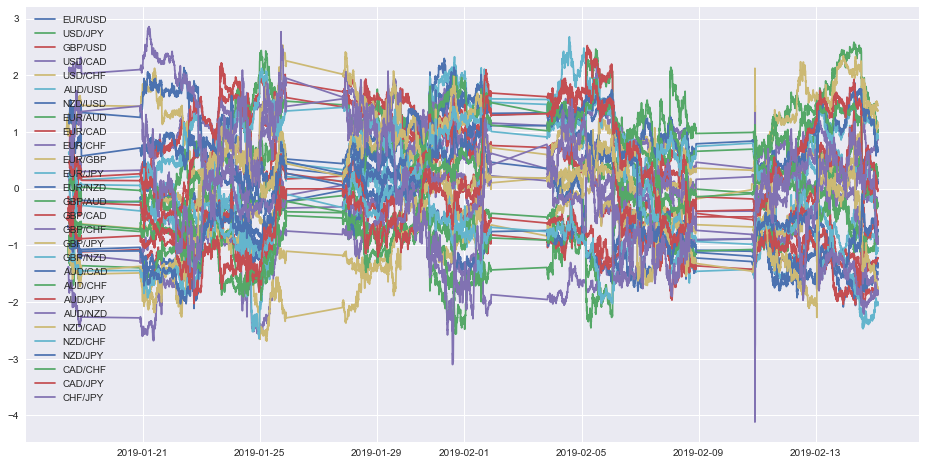

In [20]:
plt.figure(figsize=(16,8))
symbol_focus = symbols
for symbol in symbol_focus:
    plt.plot(df[symbol]['Close_z'], label=symbol)
plt.legend();

In [21]:
data = pd.DataFrame()
for symbol in symbols:
    data[symbol] = df[symbol]['Close']
data.dropna(inplace=True)

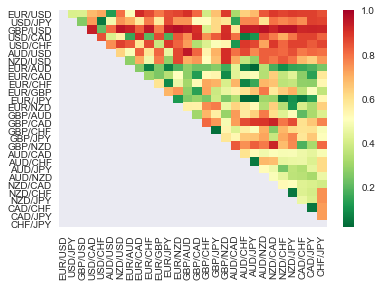

[('EUR/AUD', 'AUD/JPY'), ('EUR/JPY', 'AUD/CHF'), ('EUR/JPY', 'AUD/JPY'), ('EUR/JPY', 'NZD/CHF'), ('GBP/CHF', 'GBP/JPY')]


In [22]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
#import seaborn
#m = [0,0.2,0.4,0.6,0.8,1]
sns.heatmap(pvalues, xticklabels=symbols, 
                yticklabels=symbols, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print (pairs)

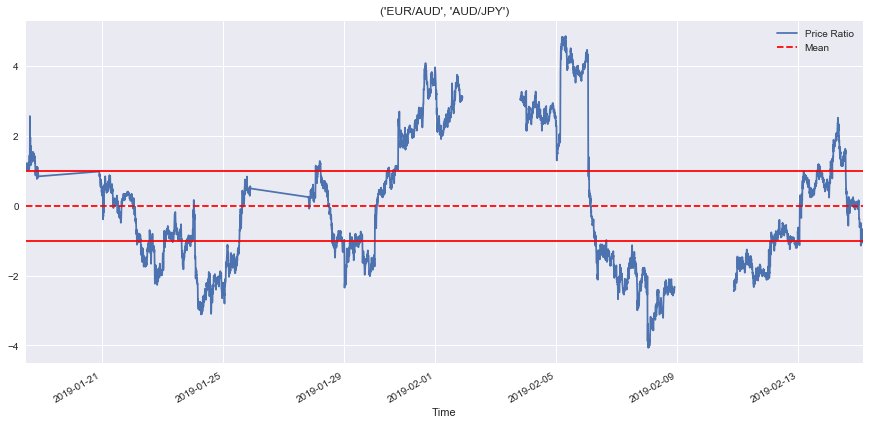

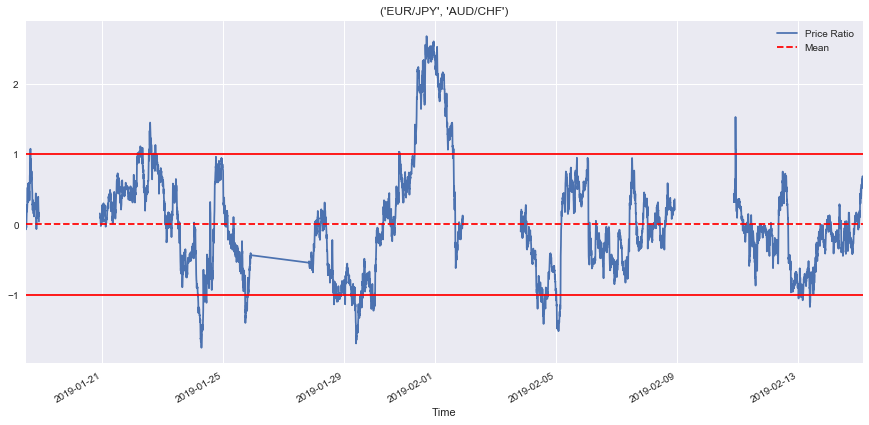

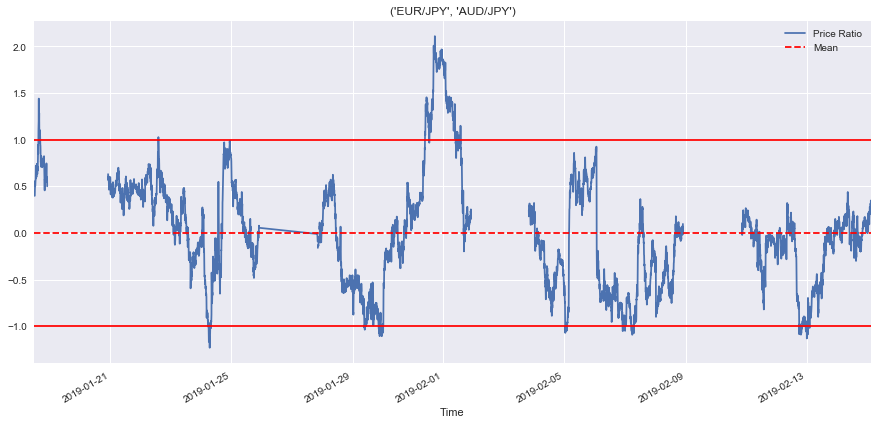

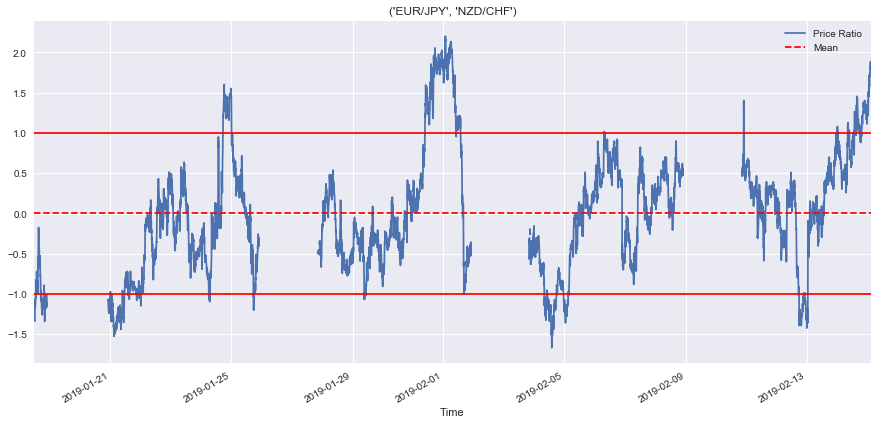

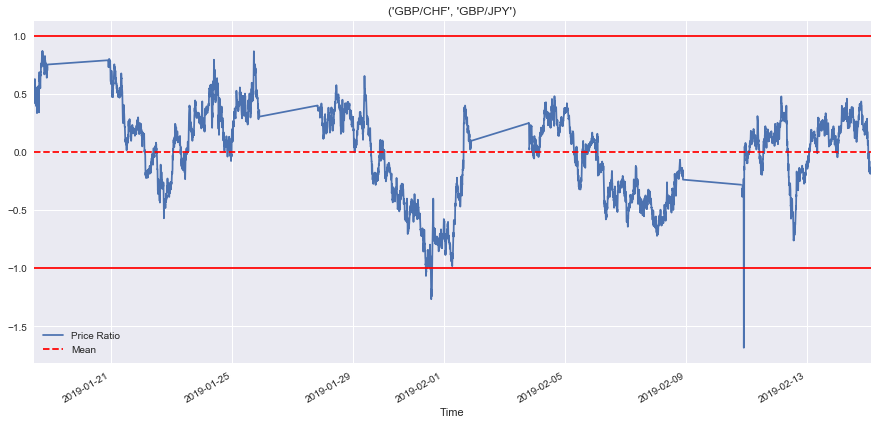

In [23]:
length = len(pairs)
for i in range(length):
    plt.title(pairs[i])
    diff = df[pairs[i][1]]['Close_z'] - df[pairs[i][0]]['Close_z']
    (diff).plot(figsize=(15,7))
    plt.axhline(np.mean(diff), color='red', linestyle='--')
    plt.axhline(y=1, color='red')
    plt.axhline(y=-1, color='red')
    plt.xlabel('Time')
    plt.legend(['Price Ratio', 'Mean'])
    plt.show()

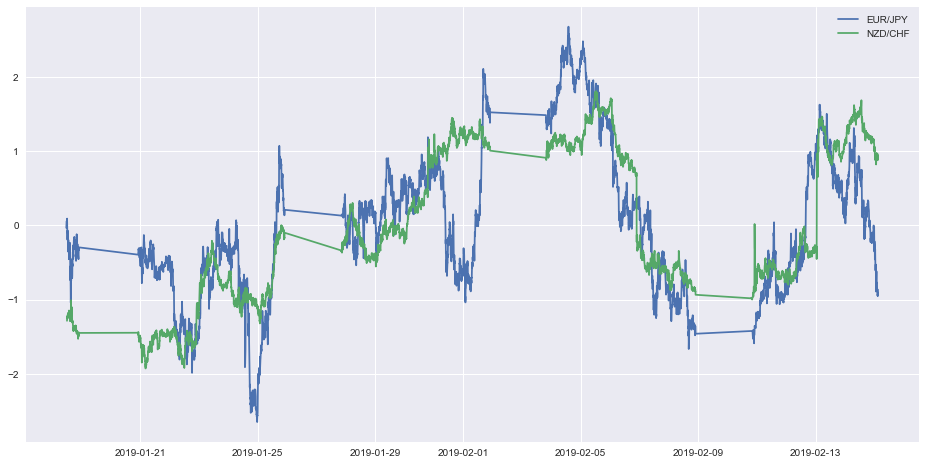

In [25]:
plt.figure(figsize=(16,8))
symbol_focus = ['EUR/JPY', 'NZD/CHF']
for symbol in symbol_focus:
    plt.plot(df[symbol]['Close_z'], label=symbol)
plt.legend();

In [ ]:
diff